# Splitting trajectories with moving pandas

For some cases, GPS tracks may leave the observation area for longer time before returning and continuing their recorded track. Therefore we might want to split trajectories at observation gaps that exceed a certain minimum duration.

In [1]:
def create_plot(data):
    # Ambil baris pertama dari DataFrame
    first_row = data.iloc[0]

    # Ambil nilai latitude dan longitude dari baris pertama
    latitude = first_row['latitude']
    longitude = first_row['longitude']
    
    m = folium.Map(location=[latitude, longitude], zoom_start=25)
    
    # Add CircleMarkers for each point
    for index, row in data.iterrows():
        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=5,  # Marker size
            color="blue",  # Marker color
            fill=True,
            fill_color="blue",  # Fill color of the marker
            fill_opacity=0.7,  # Opacity of the marker fill
            popup=f"User ID: {row['maid']}<br>Latitude: {row['latitude']}<br>Longitude: {row['longitude']}",
        ).add_to(m)
    
    return m

In [2]:
import folium
from shapely.geometry import Point, LineString

def create_plot_line(data):
    # Buat peta dengan lokasi awal berdasarkan rata-rata koordinat dari data linestring
    linestring_avg_lat = data["geometry"].apply(lambda x: x.centroid.y).mean()
    linestring_avg_lon = data["geometry"].apply(lambda x: x.centroid.x).mean()
    m = folium.Map(location=[linestring_avg_lat, linestring_avg_lon], zoom_start=15)

    # Tambahkan polyline ke peta menggunakan titik-titik dari linestring
    for linestring in data["geometry"]:
        folium.PolyLine(locations=list(linestring.coords), color='blue', weight=5, opacity=0.7).add_to(m)

    # Tambahkan CircleMarkers untuk setiap titik
    for index, row in data.iterrows():
        for point in row["geometry"].coords:
            folium.CircleMarker(
                location=[point[1], point[0]],  # Urutan koordinat diubah karena folium menggunakan (lat, lon)
                radius=5,  # Ukuran marker
                color="blue",  # Warna marker
                fill=True,
                fill_color="blue",  # Warna pengisian marker
                fill_opacity=0.7,  # Opasitas pengisian marker
                popup=f"User ID: {row['maid']}<br>Latitude: {point[1]}<br>Longitude: {point[0]}",
            ).add_to(m)

    return m

In [3]:
from shapely.geometry import LineString

def create_line(data):
    data = data.to_crs('EPSG:4326')
    data = data['geometry']
    # Buat peta dengan lokasi awal berdasarkan rata-rata koordinat dari data linestring
    avg_lat = data.apply(lambda x: x.centroid.y).mean()
    avg_lon = data.apply(lambda x: x.centroid.x).mean()
    m = folium.Map(location=[avg_lat, avg_lon], zoom_start=15)

    # Tambahkan polyline untuk setiap linestring
    for linestring in data:
        coordinates = [(lat, lon) for lon, lat in linestring.coords]
        folium.PolyLine(locations=coordinates, color='purple', weight=8, opacity=0.7).add_to(m)

    # Tambahkan GeoJson dari data GeoPandas
    folium.GeoJson(data.to_json(), name='Garis Jalan').add_to(m)

    return m

In [4]:
def bar_chart_traj(data):
    data = data.copy()
    df = pd.DataFrame(data)
    
    if 'tanggal' in df.columns:
        # Menghitung jumlah data berdasarkan tanggal
        jumlah_data_per_tanggal = df.groupby('tanggal').size()
    
    else:
        # Ambil tanggal dari kolom 'start_t' dan tambahkan sebagai kolom baru 'tanggal'
        df['tanggal'] = df['start_t'].dt.date
    
        # Menghitung jumlah data berdasarkan tanggal
        jumlah_data_per_tanggal = df.groupby('tanggal').size()
        
    # Plot bar chart
    plt.figure(figsize=(10, 6))
    jumlah_data_per_tanggal.plot(kind='bar', color='skyblue')
    plt.title(f'Jumlah Data per Tanggal: {jumlah_data_per_tanggal.sum()}')
    plt.xlabel('Tanggal')
    plt.ylabel('Jumlah Data Trajectory')
    plt.xticks(rotation=75)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [5]:
def bar_chart_maid(data):
    data = data.copy()
    df = pd.DataFrame(data)
    
    if 'tanggal' in df.columns:
        # Menghitung jumlah maid berdasarkan tanggal
        jumlah_maid_unik_per_hari = df.groupby('tanggal')['maid'].nunique()
    
    else:
        # Ambil tanggal dari kolom 'start_t' dan tambahkan sebagai kolom baru 'tanggal'
        df['tanggal'] = df['start_t'].dt.date
        
        # Menghitung jumlah maid berdasarkan tanggal
        jumlah_maid_unik_per_hari = df.groupby('tanggal')['maid'].nunique()


    # Plotting
    plt.figure(figsize=(10, 6))
    jumlah_maid_unik_per_hari.plot(kind='bar', color='skyblue')
    plt.title(f'Total Jumlah Maid Unik per Hari: {jumlah_maid_unik_per_hari.sum()}')
    plt.xlabel('Tanggal')
    plt.ylabel('Jumlah Maid Unik')
    plt.xticks(rotation=75)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [6]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import shapely as shp
import hvplot.pandas 
import matplotlib.pyplot as plt
import geoviews
import folium
import mapclassify

from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
from holoviews import opts

import warnings
warnings.filterwarnings('ignore')

plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom'], frame_width=500, frame_height=400))

mpd.show_versions()


MovingPandas 0.17.2

SYSTEM INFO
-----------
python     : 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
executable : /raid/arkham/miniconda3/envs/arkham/bin/python3
machine    : Linux-4.15.0-142-generic-x86_64-with-glibc2.27

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 3.6.2
GDAL data dir: /raid/arkham/miniconda3/envs/arkham/lib/python3.10/site-packages/fiona/gdal_data
PROJ       : 9.3.1
PROJ data dir: /raid/arkham/miniconda3/envs/arkham/lib/python3.10/site-packages/pyproj/proj_dir/share/proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.14.3
pandas     : 2.1.4
fiona      : 1.9.5
numpy      : 1.23.5
shapely    : 2.0.1
rtree      : 1.2.0
pyproj     : 3.6.1
matplotlib : 3.5.3
mapclassify: 2.6.1
geopy      : 2.4.0
holoviews  : 1.18.3
hvplot     : 0.9.2
geoviews   : 1.11.1
stonesoup  : None


In [7]:
df = pd.read_csv('../../../DataGPS_Malioboro/filter2_maljan_nov.csv')
df_grouped = df.groupby(['maid', 'tanggal'])
tdf = mpd.TrajectoryCollection(df, traj_id_col='maid', t='datetime_wib', y='latitude', x='longitude')
tdf

TrajectoryCollection with 1838 trajectories

In [8]:
#record points
len(df)

40693

In [9]:
#total maid unik per bulan
len(df.groupby(['maid']))

1942

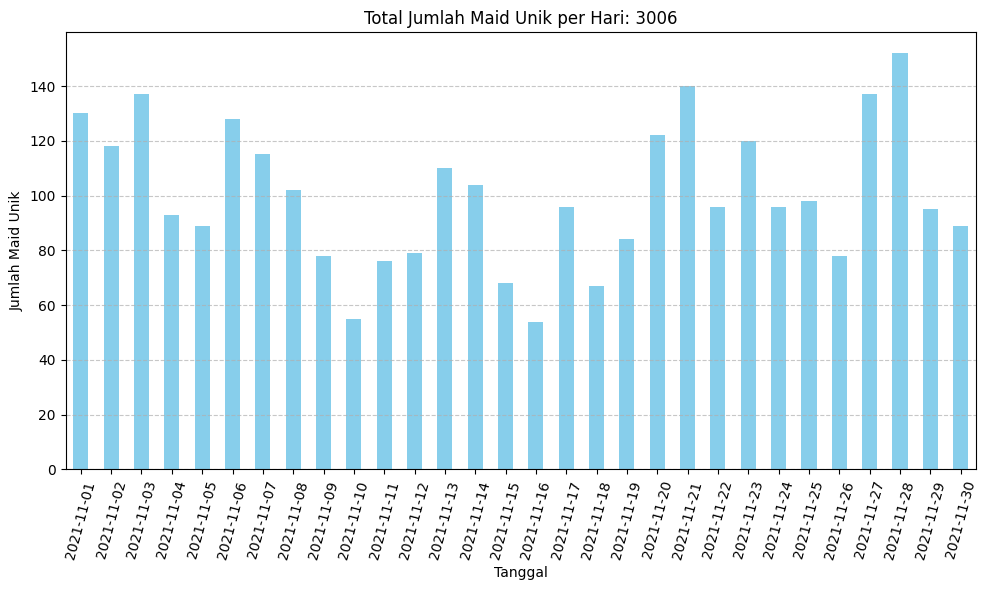

In [10]:
#total maid unik per hari
bar_chart_maid(df)

## ObservationGapSplitter
Split the trajectory where then are no observations for at least 1 minutes:

In [11]:
index = 0
df_1min = pd.DataFrame()

while index < len(tdf):
    my_traj = tdf.trajectories[index]
    split = mpd.ObservationGapSplitter(my_traj).split(gap=timedelta(minutes=1))
    if len(split) > 1:
        split_df = split.to_traj_gdf()
        df_1min = df_1min._append(split_df, ignore_index=True)
    index += 1

In [12]:
df_1min['maid'] = df_1min['maid'].apply(lambda x: x.split('_')[0])

In [13]:
# total maid unik per sebulan
df_1min['maid'].nunique()

833

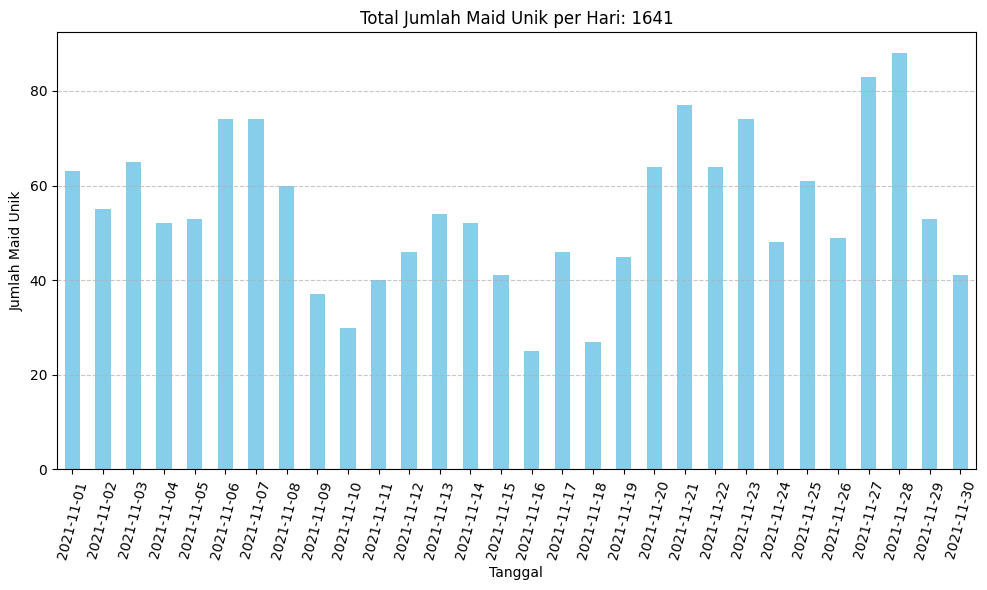

In [14]:
# total maid unik per hari
bar_chart_maid(df_1min)

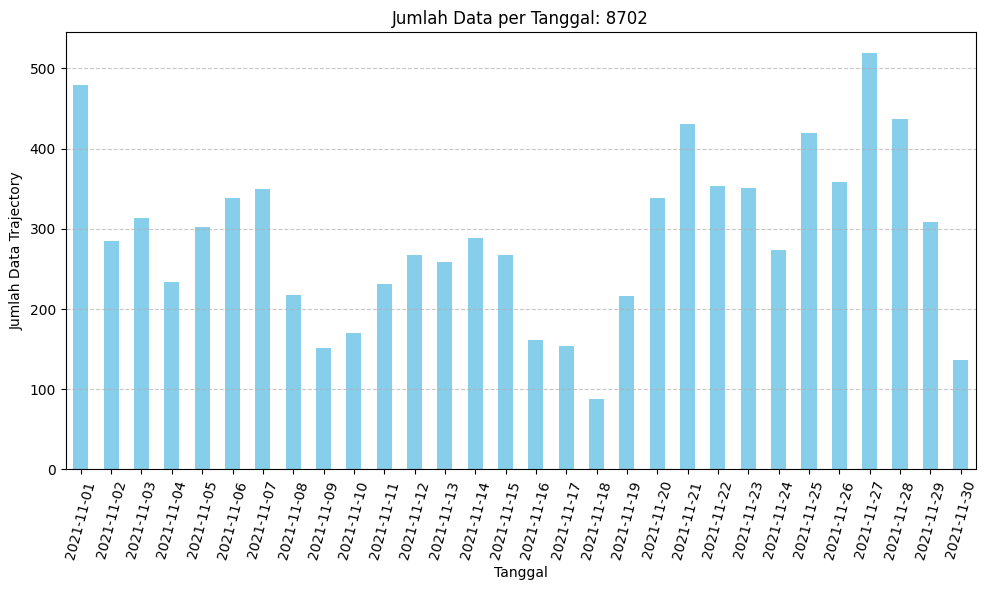

In [15]:
# total trajectory
bar_chart_traj(df_1min)

In [16]:
# apply for traj length more than 0

df_1min_length = df_1min[df_1min['length'] > 0].reset_index(drop=True)
df_1min_length= df_1min_length.sort_values(by='length', ascending=False).reset_index(drop=True)
# df_1min_length = df_1min_length.to_crs('EPSG:3857')
# df_1min_length['length_meter'] = df_1min_length['geometry'].length

In [17]:
# total maid unik per sebulan
df_1min_length['maid'].nunique()

776

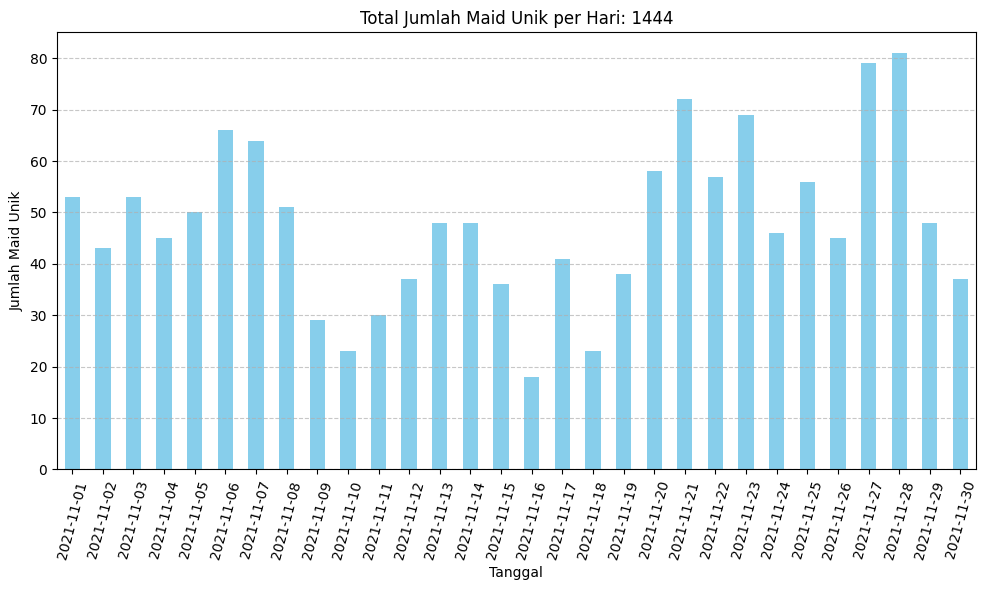

In [18]:
# total maid unik per hari
bar_chart_maid(df_1min_length)

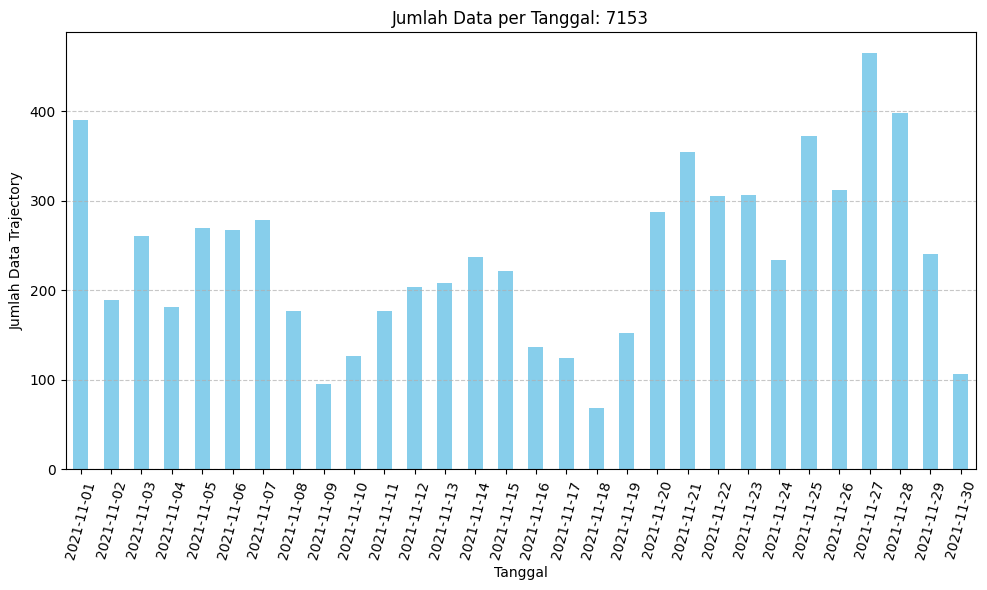

In [19]:
# total trajectory
bar_chart_traj(df_1min_length)

In [20]:
# apply for traj length >5 
df_1min_length_5met = df_1min_length[df_1min_length['length']>5]

In [21]:
# total maid unik per sebulan
df_1min_length_5met['maid'].nunique()

348

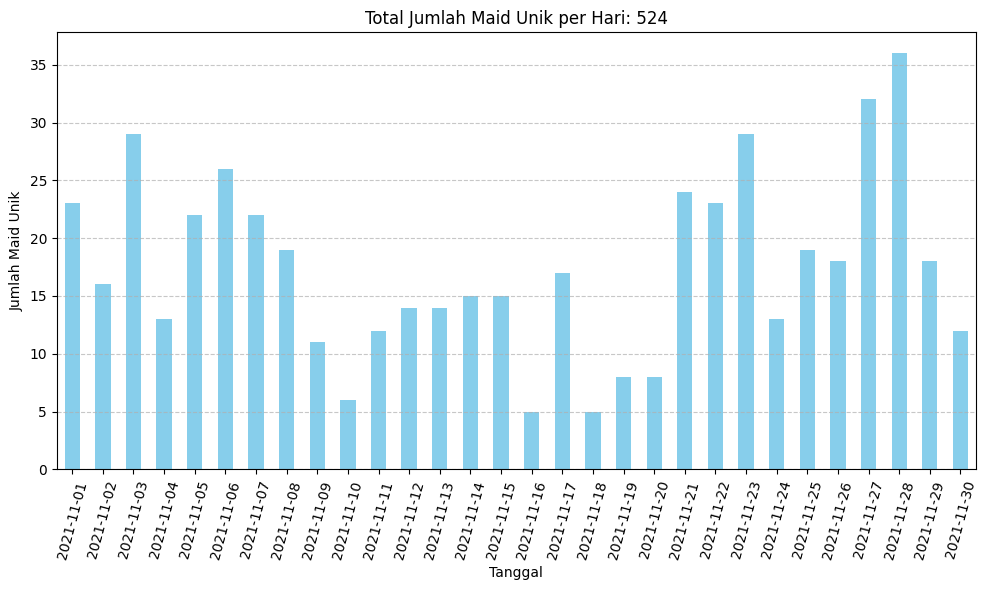

In [22]:
# total maid unik per hari
bar_chart_maid(df_1min_length_5met)

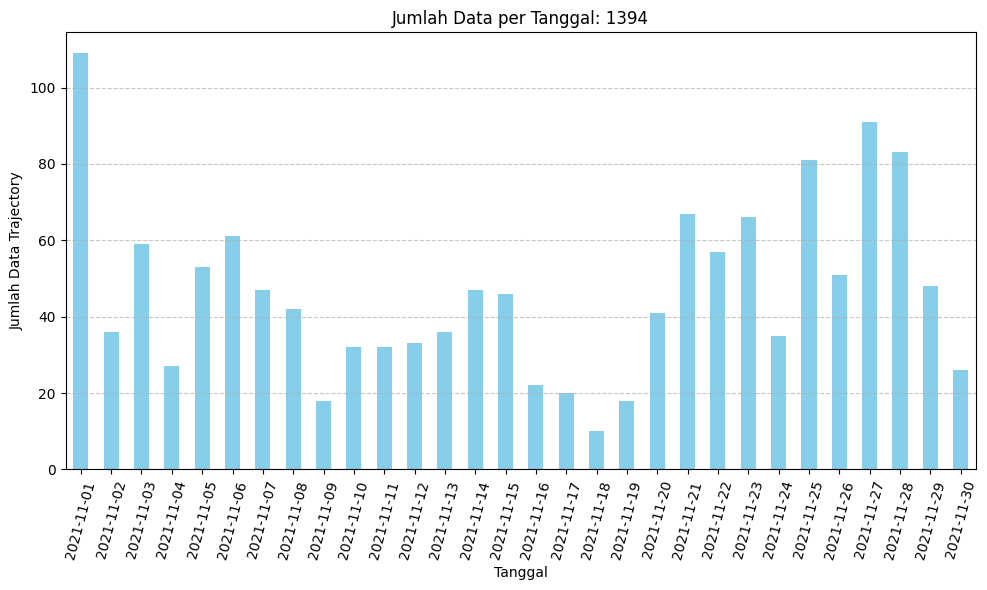

In [23]:
# total trajectory
bar_chart_traj(df_1min_length_5met)

## Map visualization

In [ ]:
create_line(df_1min_length[df_1min_length['start_t'] <'2021-12-03'])

In [ ]:
create_line(df_1min_length_sorted[:50])

In [ ]:
create_line(df_1min_length_sorted[df_1min_length_sorted['start_t'] > '2021-12-22'])

In [ ]:
bar_chart_traj(df_1min_length_sorted)

In [ ]:
bar_chart_maid(df_1min_length_sorted)

In [ ]:
len(df_1min_length_sorted)